https://www.kaggle.com/xhlulu/ieee-fraud-xgboost-with-gpu-fit-in-40s

In [1]:
import re
import pandas as pd
import numpy as np
import multiprocessing
import gc
from tqdm import tqdm_notebook
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 999)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train_id = pd.read_csv('../input/train_identity.csv')
train_tr = pd.read_csv('../input/train_transaction.csv')
test_id = pd.read_csv('../input/test_identity.csv')
test_tr = pd.read_csv('../input/test_transaction.csv')
sub = pd.read_csv('../input/sample_submission.csv')

train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect()

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [17]:
for col in train.columns:
    if train[col].dtype == 'object':
        train_uniques = set(train[col].dropna().unique())
        test_uniques = set(train[col].dropna().unique())
        
        diff = train_uniques - test_uniques
        print(col, diff)
        

ProductCD set()
card4 set()
card6 set()
P_emaildomain set()
R_emaildomain set()
M1 set()
M2 set()
M3 set()
M4 set()
M5 set()
M6 set()
M7 set()
M8 set()
M9 set()
id_12 set()
id_15 set()
id_16 set()
id_23 set()
id_27 set()
id_28 set()
id_29 set()
id_30 set()
id_31 set()
id_33 set()
id_34 set()
id_35 set()
id_36 set()
id_37 set()
id_38 set()
DeviceType set()
DeviceInfo set()


In [18]:
def select_cols_to_drop(df):
    one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
    many_null_cols = [col for col in df.columns if df[col].isnull().sum() / df.shape[0] > 0.9]
    big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return one_value_cols + many_null_cols + big_top_value_cols

In [19]:
# cols_to_drop = list(set(select_cols_to_drop(train) + select_cols_to_drop(test)))
# cols_to_drop.remove('isFraud')

# train = train.drop(cols_to_drop, axis=1)
# test = test.drop(cols_to_drop, axis=1)

In [20]:
import re

def select_columns_regexp(df, regexp):
    return [c for c in df.columns if re.search(regexp, c)]

In [21]:
train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

In [22]:
card_cols = select_columns_regexp(train, r'card\d+')
C_cols = select_columns_regexp(train, r'C\d+')
D_cols = select_columns_regexp(train, r'D\d+')
V_cols = select_columns_regexp(train, r'V\d+')
M_cols = select_columns_regexp(train, r'M\d+')
id_cols = select_columns_regexp(train, r'id_\d+')
addr_cols = select_columns_regexp(train, r'addr\d+')

## IsFraud

In [23]:
is_fraud = train['isFraud'] == 1

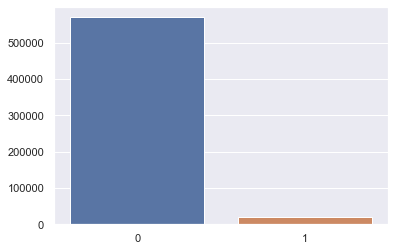

In [24]:
fraud_counts = train['isFraud'].value_counts()
sns.barplot(fraud_counts.index, fraud_counts.values)

## Transaction Amount

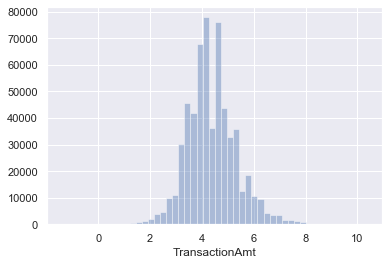

In [25]:
sns.distplot(np.log(train['TransactionAmt']), kde=None)

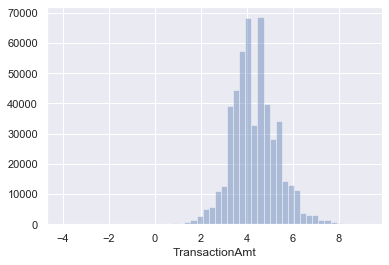

In [26]:
sns.distplot(np.log(test['TransactionAmt']), kde=None)

In [92]:
def heatmap(corr, figsize=(6, 6)):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask, k=1)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap=cmap, square=True, linewidths=0.2, cbar_kws={"shrink": .5}, ax=ax)

In [28]:
train[C_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 14 columns):
C1     590540 non-null float16
C2     590540 non-null float16
C3     590540 non-null float16
C4     590540 non-null float16
C5     590540 non-null float16
C6     590540 non-null float16
C7     590540 non-null float16
C8     590540 non-null float16
C9     590540 non-null float16
C10    590540 non-null float16
C11    590540 non-null float16
C12    590540 non-null float16
C13    590540 non-null float16
C14    590540 non-null float16
dtypes: float16(14)
memory usage: 20.3 MB


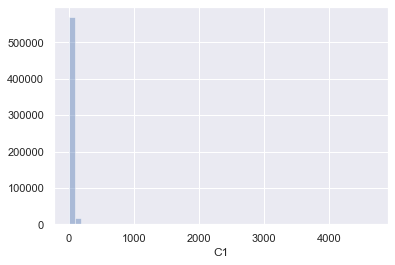

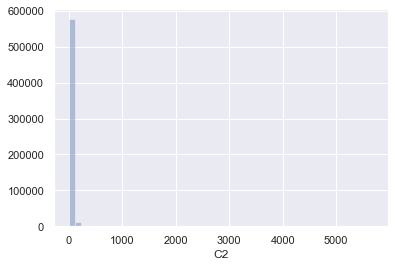

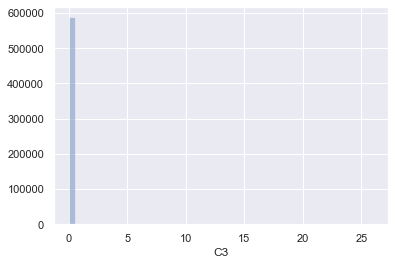

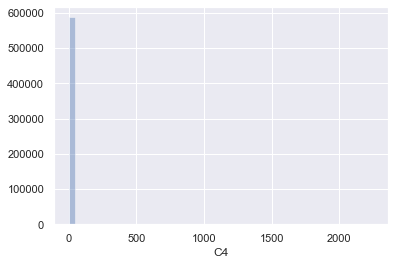

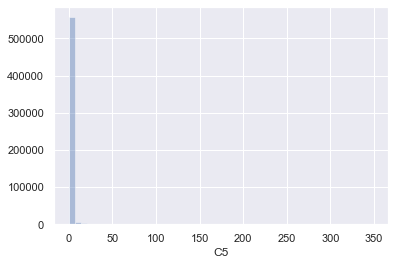

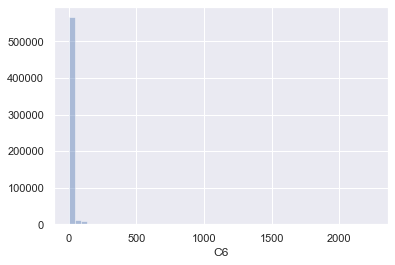

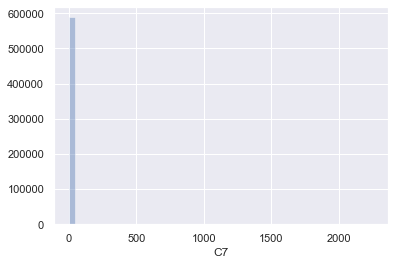

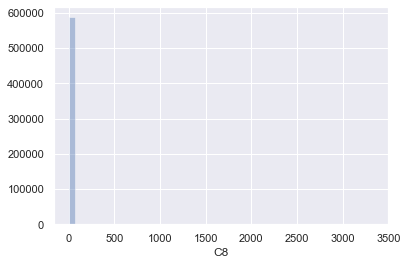

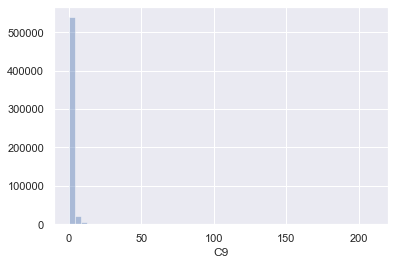

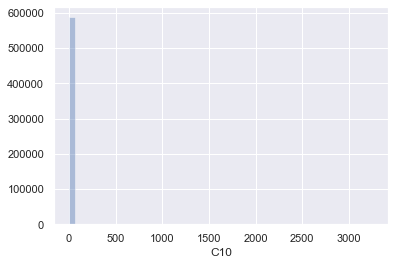

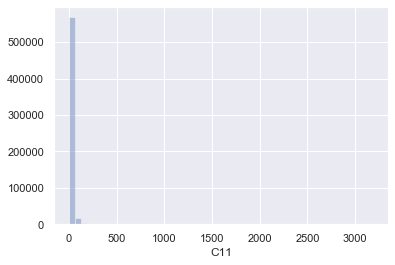

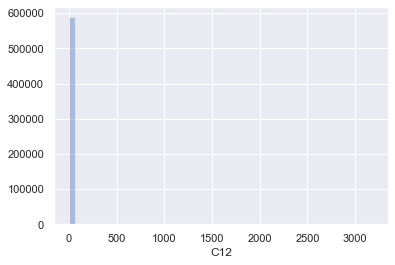

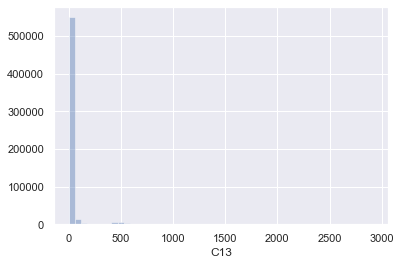

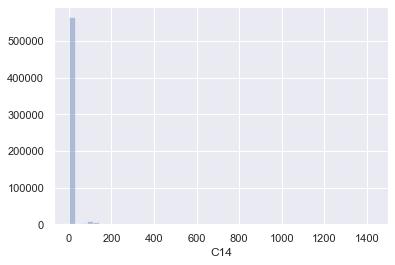

In [29]:
for col in C_cols:
    sns.distplot(train[col], kde=None)
    plt.show()

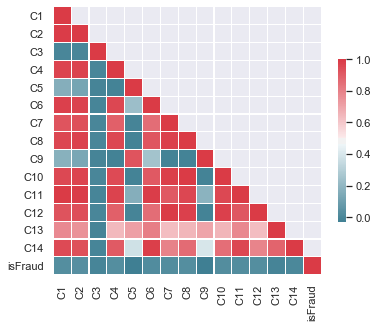

In [30]:
heatmap(train[C_cols + ['isFraud']].corr())

In [31]:
train['C3'].value_counts()

0.0     588111
1.0       2137
2.0        180
3.0         58
4.0          7
16.0         6
9.0          5
11.0         5
5.0          3
13.0         3
14.0         3
10.0         2
8.0          2
12.0         2
15.0         2
7.0          2
17.0         2
6.0          1
19.0         1
20.0         1
21.0         1
22.0         1
23.0         1
24.0         1
25.0         1
26.0         1
18.0         1
Name: C3, dtype: int64

In [32]:
train[card_cols + ['isFraud']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 7 columns):
card1      590540 non-null int16
card2      581607 non-null float16
card3      588975 non-null float16
card4      588963 non-null object
card5      586281 non-null float16
card6      588969 non-null object
isFraud    590540 non-null int8
dtypes: float16(3), int16(1), int8(1), object(2)
memory usage: 18.6+ MB


## Card cols

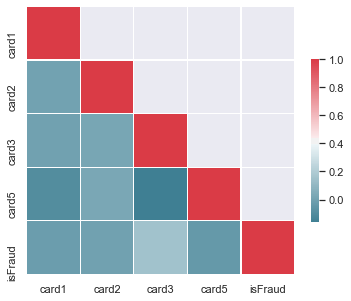

In [33]:
heatmap(train[card_cols + ['isFraud']].corr())

In [34]:
train['card4'].value_counts()

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

In [35]:
train['card6'].value_counts()

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

In [36]:
test['card4'].value_counts()

visa                334882
mastercard          158169
american express      7681
discover              2873
Name: card4, dtype: int64

In [37]:
train['card1'].value_counts()

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
12695     7091
12544     6773
6019      6771
2803      6141
7585      5334
10616     5172
12839     5129
3154      4614
2616      4410
18132     4209
9633      4158
15497     3977
16132     3929
2884      3873
16075     3748
11207     3693
10112     3560
7508      3490
10057     3166
12501     3152
7826      3006
16659     2988
12577     2891
5812      2818
7664      2792
         ...  
15229        1
7772         1
12456        1
16550        1
5218         1
3958         1
1911         1
7342         1
11944        1
8572         1
4369         1
15463        1
10621        1
11365        1
2937         1
9084         1
3169         1
3859         1
13182        1
17776        1
3449         1
5498         1
7547         1
4706         1
2657         1
12390        1
10341        1
10006        1
15743        1
17105        1
Name: card1, Length: 13553, dtype: int64

In [38]:
train['card1'].nunique()

13553

In [39]:
train['card4'].value_counts()

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

## M cols

In [40]:
train[M_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 9 columns):
M1    319440 non-null object
M2    319440 non-null object
M3    319440 non-null object
M4    309096 non-null object
M5    240058 non-null object
M6    421180 non-null object
M7    244275 non-null object
M8    244288 non-null object
M9    244288 non-null object
dtypes: object(9)
memory usage: 45.1+ MB


In [41]:
train[M_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## id cols

In [42]:
train[id_cols].head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


In [43]:
train[id_cols].nunique()

id_01        77
id_02    115655
id_03        24
id_04        15
id_05        93
id_06       101
id_07        84
id_08        94
id_09        46
id_10        62
id_11       146
id_12         2
id_13        54
id_14        25
id_15         3
id_16         2
id_17       104
id_18        18
id_19       522
id_20       394
id_21       490
id_22        25
id_23         3
id_24        12
id_25       341
id_26        95
id_27         2
id_28         2
id_29         2
id_30        75
id_31       130
id_32         4
id_33       260
id_34         4
id_35         2
id_36         2
id_37         2
id_38         2
dtype: int64

In [44]:
train[id_cols].isna().sum() / len(train)

id_01    0.755761
id_02    0.761452
id_03    0.887689
id_04    0.887689
id_05    0.768238
id_06    0.768238
id_07    0.991271
id_08    0.991271
id_09    0.873123
id_10    0.873123
id_11    0.761273
id_12    0.755761
id_13    0.784401
id_14    0.864456
id_15    0.761261
id_16    0.780980
id_17    0.763997
id_18    0.923607
id_19    0.764084
id_20    0.764180
id_21    0.991264
id_22    0.991247
id_23    0.991247
id_24    0.991962
id_25    0.991310
id_26    0.991257
id_27    0.991247
id_28    0.761273
id_29    0.761273
id_30    0.868654
id_31    0.762451
id_32    0.868619
id_33    0.875895
id_34    0.868248
id_35    0.761261
id_36    0.761261
id_37    0.761261
id_38    0.761261
dtype: float64

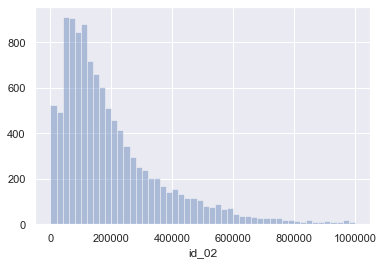

In [45]:
sns.distplot(train[is_fraud]['id_02'].dropna(), kde=None)

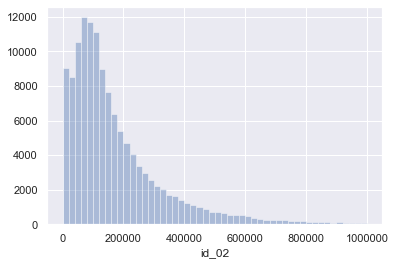

In [46]:
sns.distplot(train[~is_fraud]['id_02'].dropna(), kde=None)

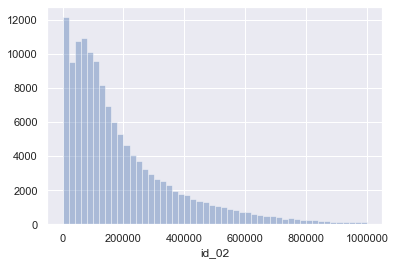

In [47]:
sns.distplot(test['id_02'].dropna(), kde=None)

In [48]:
train[id_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 38 columns):
id_01    144233 non-null float16
id_02    140872 non-null float32
id_03    66324 non-null float16
id_04    66324 non-null float16
id_05    136865 non-null float16
id_06    136865 non-null float16
id_07    5155 non-null float16
id_08    5155 non-null float16
id_09    74926 non-null float16
id_10    74926 non-null float16
id_11    140978 non-null float16
id_12    144233 non-null object
id_13    127320 non-null float16
id_14    80044 non-null float16
id_15    140985 non-null object
id_16    129340 non-null object
id_17    139369 non-null float16
id_18    45113 non-null float16
id_19    139318 non-null float16
id_20    139261 non-null float16
id_21    5159 non-null float16
id_22    5169 non-null float16
id_23    5169 non-null object
id_24    4747 non-null float16
id_25    5132 non-null float16
id_26    5163 non-null float16
id_27    5169 non-null object
id_28    140978 non-null ob

## addr

In [95]:
2 ** 31

1534236469

2147483648

In [49]:
train[addr_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 2 columns):
addr1    524834 non-null float16
addr2    524834 non-null float16
dtypes: float16(2)
memory usage: 6.8 MB


In [50]:
train[addr_cols].head()

,addr1,addr2
0,315.0,87.0
1,325.0,87.0
2,330.0,87.0
3,476.0,87.0
4,420.0,87.0


In [51]:
train['addr2'].value_counts()

87.0     520481
60.0       3084
96.0        638
32.0         91
65.0         82
16.0         55
31.0         47
19.0         33
26.0         25
27.0         20
59.0         17
69.0         17
34.0         16
43.0         12
98.0         11
29.0         11
102.0        11
68.0         10
57.0         10
78.0          8
10.0          8
17.0          7
71.0          7
13.0          7
54.0          6
72.0          6
88.0          5
52.0          5
73.0          5
21.0          5
          ...  
24.0          3
20.0          3
74.0          3
92.0          2
36.0          2
23.0          2
76.0          2
86.0          2
100.0         2
63.0          2
97.0          2
66.0          2
77.0          1
84.0          1
35.0          1
22.0          1
94.0          1
93.0          1
15.0          1
89.0          1
75.0          1
25.0          1
14.0          1
83.0          1
82.0          1
55.0          1
79.0          1
49.0          1
50.0          1
70.0          1
Name: addr2, Length: 74,

## V columns

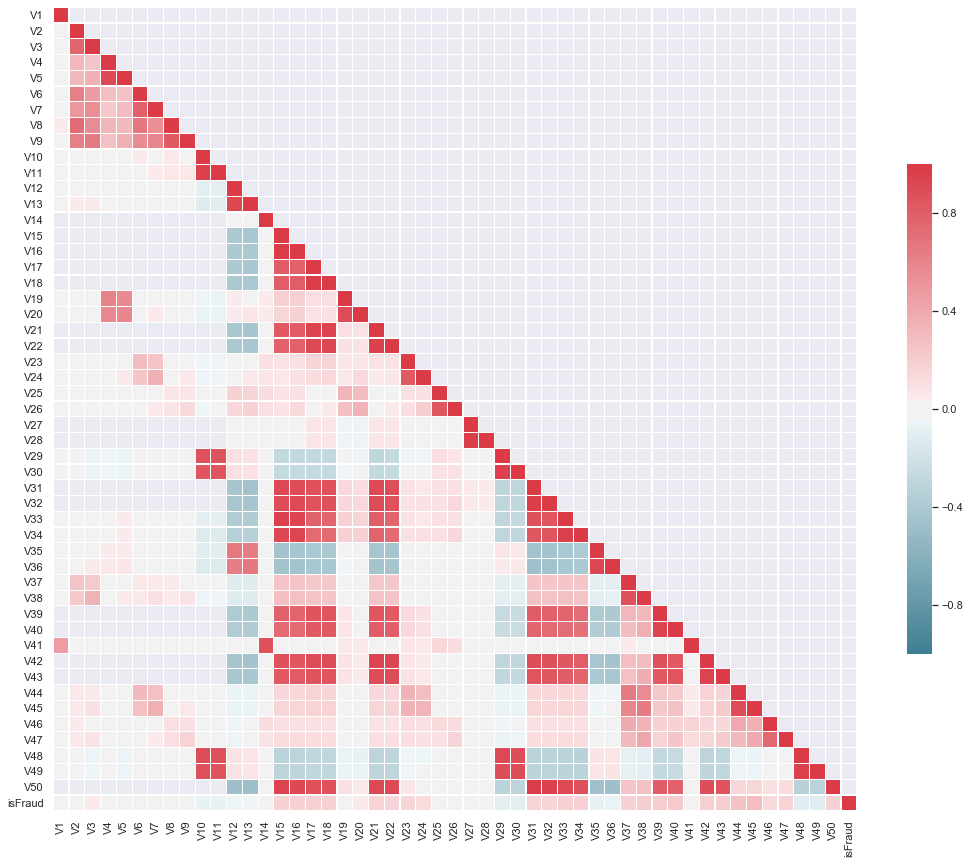

In [93]:
heatmap(train[V_cols[:50] + ['isFraud']].corr(), figsize=(18, 18))

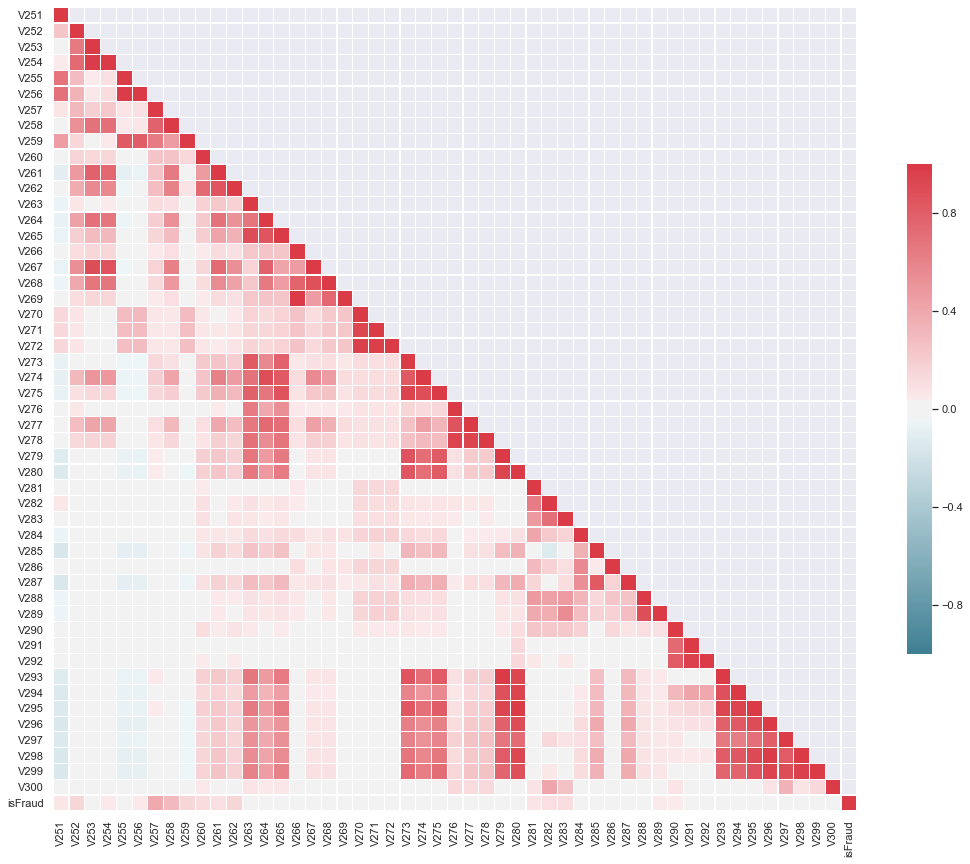

In [94]:
heatmap(train[V_cols[250:300] + ['isFraud']].corr(), figsize=(18, 18))

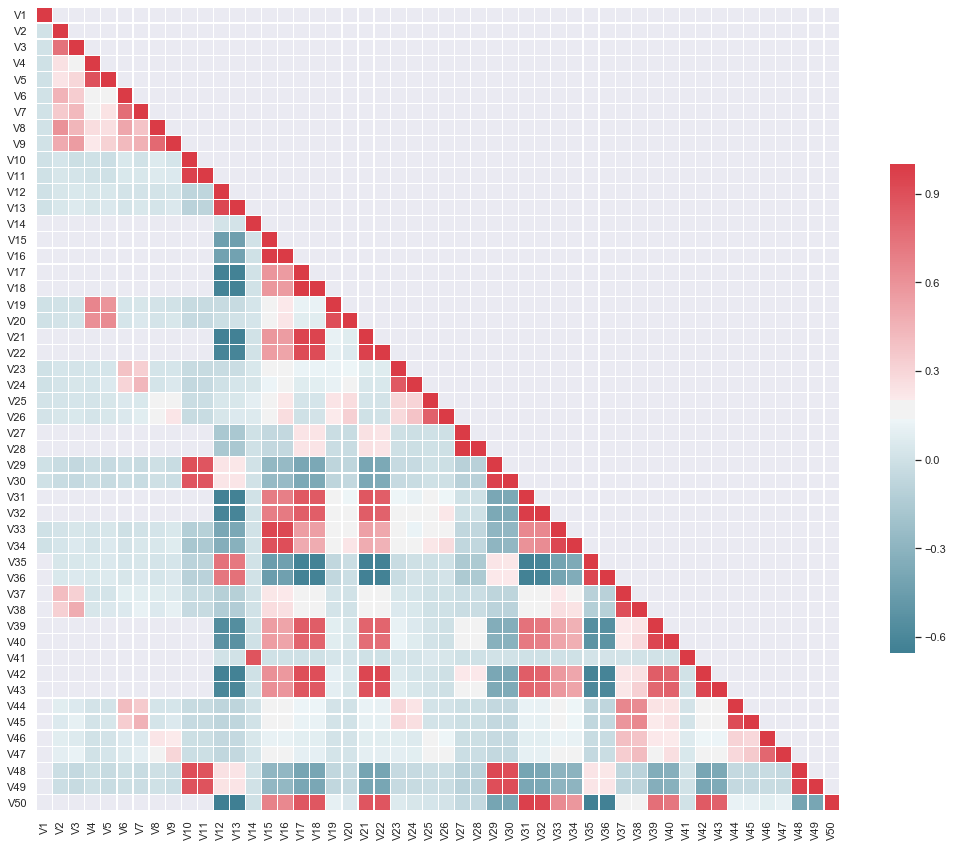

In [89]:
heatmap(test[V_cols[:50]].corr(), figsize=(18, 18))

In [85]:
tr = pd.DataFrame({'a': [0, 1, 2], 'b': [10, 20, 30]})
te = pd.DataFrame({'a': [0, 1, 3], 'b': [40, 50, 60]})
tr_te = pd.concat((tr, te), axis=0)

aggs = {'b': ['min', 'max', 'mean', 'std']}
agg = tr_te.groupby('a').agg(aggs)
print(agg.columns)
print(dir(agg.columns))
new_columns = ['{0}_{1}'.format(c0, c1) for c0 in agg.columns.levels[0] for c1 in agg.columns.levels[1]]
agg.columns = new_columns
agg

MultiIndex(levels=[['b'], ['min', 'max', 'mean', 'std']],
           codes=[[0, 0, 0, 0], [0, 1, 2, 3]])
['T', '__abs__', '__add__', '__and__', '__array__', '__array_priority__', '__array_wrap__', '__bool__', '__bytes__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__divmod__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getslice__', '__gt__', '__hash__', '__iadd__', '__init__', '__init_subclass__', '__inv__', '__isub__', '__iter__', '__le__', '__len__', '__lt__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pos__', '__pow__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmul__', '__rpow__', '__rsub__', '__rtruediv__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__unicode__', '__weakref__', '__xor__', '_accessors', '_add_compari

,b_min,b_max,b_mean,b_std
a,,,,
0,10,40,25,21.213203
1,20,50,35,21.213203
2,30,30,30,NaN
3,60,60,60,NaN


In [86]:
tr.merge(agg, on='a')

,a,b,b_min,b_max,b_mean,b_std
0,0,10,10,40,25,21.213203
1,1,20,20,50,35,21.213203
2,2,30,30,30,30,NaN


In [72]:
tr.merge(agg, on='a')

,a,b,b_min,b_max,b_mean
0,0,10,10,40,25
1,1,20,20,50,35
2,2,30,30,30,30
